# Animal Image Classification

**Author:** Davyd Antoniuk 

**Project Goal:** Build and compare deep learning models (CNN, advanced CNN, and Transfer Learning) to classify images of animals into 10 categories.

## 1. Introduction

This project explores different architectures, from simple CNNs to pre-trained models, analyzing their performance on the [Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10) dataset. The goal is to find the best model in terms of accuracy, efficiency, and generalization.

## 2. Data Preparation & Exploration

In [33]:
import os
import shutil
import random
from collections import Counter
import matplotlib.pyplot as plt
import cv2

import torch
from sklearn.model_selection import train_test_split
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

### 2.1 Dataset overview

The Animals-10 dataset contains images of 10 animal classes: `dog`, `cat`, `horse`, `spider`, `butterfly`, `chicken`, `cow`, `sheep`, `squirrel`, `elephant`. The dataset is organized into folders, but the class names are in Italian language. I will translate them to English for clarity before processing.

Now, let's load and explore the dataset!

### 2.2 Load and Preprocess Dataset

**Step 1:** Define Paths and Translations

*Set the dataset path and create a dictionary to rename folders from Italian to English.*

In [2]:
# Original dataset path
data_path = "data"

# Translation dictionary (Italian → English)
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "scoiattolo": "squirrel", "ragno": "spider"
}

**Step 2:** Rename Folders to English

*Rename all class folders using the translation dictionary.*

In [3]:
for folder in os.listdir(data_path):
    if folder in translate:
        old_folder = os.path.join(data_path, folder)
        new_folder = os.path.join(data_path, translate[folder])
        os.rename(old_folder, new_folder)

print("Folders renamed successfully!")

Folders renamed successfully!


**Step 3:** Count Images per Class

*Count and visualize how many images each class has*

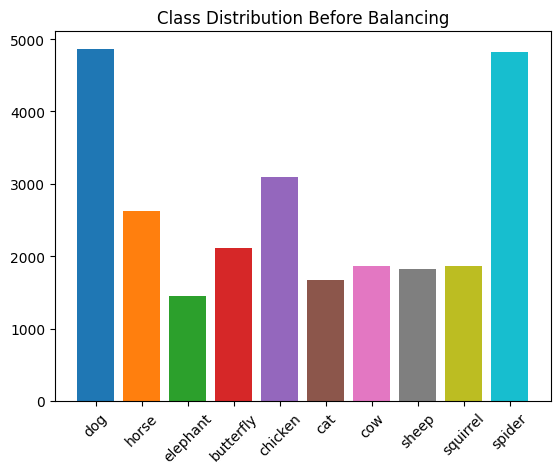

In [13]:
class_counts = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in translate.values()}
colors = plt.cm.tab10(range(len(class_counts)))
# Plot class distribution
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xticks(rotation=45)
plt.title("Class Distribution Before Balancing")
plt.show()

The dataset is imbalanced - **dogs** and **spiders** have the most images, while **elephants** have the least. However, this isn’t a problem because I will reduce each class to *200 images* to ensure fair training and manage computational resources efficiently.

**Step 4:** Balance the Dataset 

*Reduce each class to 200 images to manage computational resources.*

In [ ]:
target_count = 200

for cls in translate.values():
    class_path = os.path.join(data_path, cls)
    images = os.listdir(class_path)
    
    # Keep only the first 200 images
    for img in images[target_count:]:
        os.remove(os.path.join(class_path, img))

print("Dataset balanced: Each class now has 200 images.")

Dataset balanced: Each class now has 200 images.


**Step 6:** Verify New Distribution

*Confirm that each class now contains 200 images.*

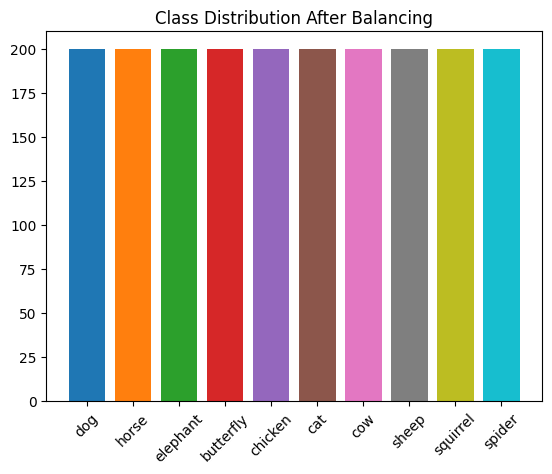

In [16]:
new_class_counts = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in translate.values()}

colors = plt.cm.tab10(range(len(new_class_counts)))
plt.bar(new_class_counts.keys(), new_class_counts.values(), color=colors)
plt.xticks(rotation=45)
plt.title("Class Distribution After Balancing")
plt.show()

Now every class has the same number of images, and I can move on to the next stage

### 2.3 Detailed Dataset Exploration

**Step 1:** Define the Visualization Function

Now, let's visualize random images from the dataset to better understand the data distribution and quality. Below is a function to display a grid of random images with their corresponding class labels. The function allows specifying the number of images to visualize dynamically.

In [18]:
def visualize_random_images(folder, num_images=9):
    """
    Displays a grid of random images from the dataset.
    
    Args:
        folder (str): Path to the dataset folder.
        num_images (int): Number of images to visualize.
    """
    # Get all class names (folders)
    class_names = os.listdir(folder)
    
    # Collect random images with labels
    images = []
    labels = []
    
    for _ in range(num_images):
        selected_class = random.choice(class_names)  # Choose a random class
        class_path = os.path.join(folder, selected_class)
        image_name = random.choice(os.listdir(class_path))  # Choose a random image
        image_path = os.path.join(class_path, image_name)
        
        # Read and store the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        images.append(img)
        labels.append(selected_class)

    # Determine the grid size dynamically
    grid_size = int(num_images ** 0.5)  # Find the closest square root
    while grid_size * grid_size < num_images:
        grid_size += 1  # Adjust for non-perfect squares

    # Set figure size dynamically
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
    fig.suptitle("Random Sample Images", fontsize=14)

    # Flatten axes for easy iteration (handles cases where grid isn't perfect)
    axes = axes.flatten()

    for i in range(grid_size * grid_size):
        if i < num_images:
            axes[i].imshow(images[i])
            axes[i].set_title(labels[i])
        axes[i].axis('off')  # Hide axes

    plt.show()

**Step 2:** Visualize Random Images

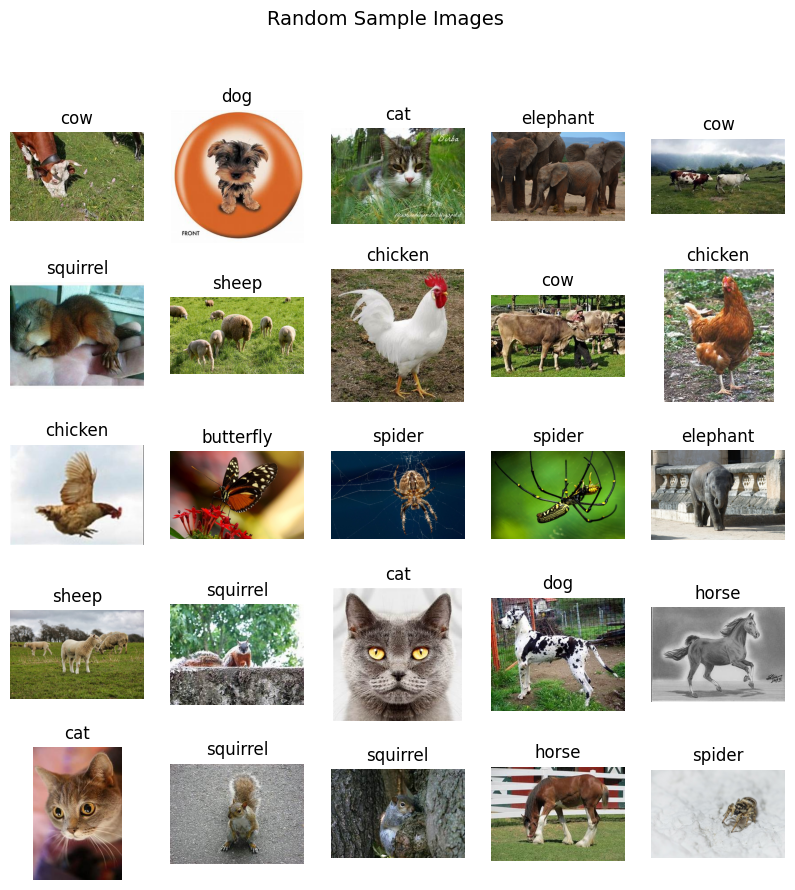

In [22]:
visualize_random_images("data", num_images=25)

The images are **well-labeled** and **clearly represent** their respective classes. The dataset quality looks good for training, so we can proceed to the next step: **image preprocessing**.

### 2.4 Train-Validation-Test Split

I will split the dataset into Train (70%), Validation (15%), and Test (15%), ensuring each class has exactly 200 images.



**Step 1:** Define Paths and Create Split Folders

*Create separate folders for train, validation, and test sets.*

In [24]:
# Define paths
dataset_path = "data"
split_path = "split_data"

# Create train, val, and test directories
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(split_path, split), exist_ok=True)

**Step 2:** Perform Train-Validation-Test Split

*Split images and copy them into new structured folders.*

In [25]:
split_ratio = {"train": 0.7, "val": 0.15, "test": 0.15}

for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    
    # Shuffle and split images
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - split_ratio["train"]), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=split_ratio["test"] / (split_ratio["val"] + split_ratio["test"]), random_state=42)
    
    # Copy images to respective folders
    for split, img_list in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        split_class_path = os.path.join(split_path, split, cls)
        os.makedirs(split_class_path, exist_ok=True)
        
        for img in img_list:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(split_class_path, img)
            shutil.copy(src_path, dst_path)

print("Dataset successfully split into Train, Validation, and Test sets!")

Dataset successfully split into Train, Validation, and Test sets!


**Step 3:** Visualize Class Distribution After Splitting

*Plot the number of images per class for Train, Validation, and Test sets.*

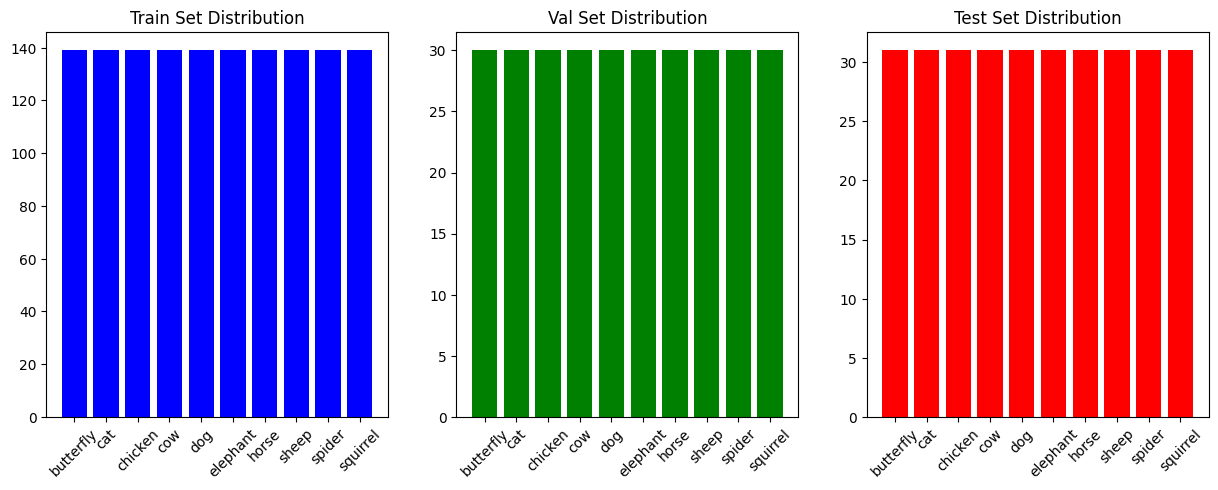

In [30]:
# Count images in each split
split_counts = {"train": {}, "val": {}, "test": {}}

for split in ["train", "val", "test"]:
    for cls in os.listdir(os.path.join(split_path, split)):
        split_counts[split][cls] = len(os.listdir(os.path.join(split_path, split, cls)))

# Define colors for each split
colors = {"train": "blue", "val": "green", "test": "red"}

# Plot class distribution per split
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
splits = ["train", "val", "test"]

for i, split in enumerate(splits):
    axes[i].bar(split_counts[split].keys(), split_counts[split].values(), color=colors[split])
    axes[i].set_title(f"{split.capitalize()} Set Distribution")
    axes[i].set_xticks(range(len(split_counts[split].keys())))
    axes[i].set_xticklabels(split_counts[split].keys(), rotation=45)

plt.show()

Each set has the same number of images per class.

The dataset is successfully split, and each class has the correct number of images. Now, we can move to image preprocessing!

### 2.5 Image Preprocessing

Now, I will **prepare the images for model training** by applying **augmentation**, **normalization**, and **resizing** while ensuring different models receive the correct preprocessing.

Since different models require different preprocessing, I will create two versions of the dataset:
- Standardized dataset → For **Random Forest**, **XGBoost**, **FNN**, **CNN**
- Lightly Processed dataset → For Transfer Learning models (ResNet, VGG, EfficientNet, etc.)

#### 2.5.1 Define Image Transformations

1. **Apply Data Augmentation (Only for Training Set)**\
As discussed [here](https://datascience.stackexchange.com/questions/86356/first-perform-data-augmentation-or-normalization), augmentation must be applied before normalization to avoid distorting pixel distributions.

2. **Apply Normalization (For RF, XGBoost, FNN, CNN)**\
As discussed [here](https://datascience.stackexchange.com/questions/94537/normalization-vs-standardization-for-image-classification-problem), normalization works better than standardization for deep learning models since it helps capture relations inside images more effectively.

*Applied augmentation (for training only) and normalization where needed.*

In [ ]:
IMAGE_SIZE = (224, 224)

# Augmentation + Normalization (For CNN, FNN, RF, XGBoost)
standardized_train_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip image with 50% chance
    transforms.RandomRotation(15),  # Rotate randomly by 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust colors
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),  # Random zoom
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization
])

# Only Normalization (Validation & Test - No Augmentation)
standardized_test_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization
])

#  Only Resize (For Transfer Learning Models)
transfer_learning_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()  # No normalization, as pre-trained models handle it
])

#### 2.5.2 Load the Dataset


*Loaded datasets with the correct preprocessing for each model type.*

In [38]:
# Paths to datasets
train_path = "split_data/train"
val_path = "split_data/val"
test_path = "split_data/test"

# Load datasets with respective transformations
standardized_train_dataset = datasets.ImageFolder(root=train_path, transform=standardized_train_transforms)
standardized_val_dataset = datasets.ImageFolder(root=val_path, transform=standardized_test_transforms)
standardized_test_dataset = datasets.ImageFolder(root=test_path, transform=standardized_test_transforms)

transfer_train_dataset = datasets.ImageFolder(root=train_path, transform=transfer_learning_transforms)
transfer_val_dataset = datasets.ImageFolder(root=val_path, transform=transfer_learning_transforms)
transfer_test_dataset = datasets.ImageFolder(root=test_path, transform=transfer_learning_transforms)

print("Datasets successfully loaded with augmentation and transformations!")

Datasets successfully loaded with augmentation and transformations!


#### 2.5.3 Create Data Loaders

*Created efficient batch loaders for each dataset version.*

In [39]:
BATCH_SIZE = 32

# Standardized dataset loaders (For CNN, FNN, RF, XGBoost)
standardized_train_loader = DataLoader(standardized_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
standardized_val_loader = DataLoader(standardized_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
standardized_test_loader = DataLoader(standardized_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Transfer Learning dataset loaders
transfer_train_loader = DataLoader(transfer_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
transfer_val_loader = DataLoader(transfer_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
transfer_test_loader = DataLoader(transfer_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


#### 2.5.4 Verify Preprocessing (Visualization at Each Step)

To understand better how work image preprocessing, I will visualize a random images before and after applying augmentation and normalization.

**Function to Visualize Original Images (Before Processing)**

In [43]:
def show_original_images(folder, num_images=5):
    """ Display original images from dataset """
    class_names = os.listdir(folder)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        selected_class = random.choice(class_names)
        class_path = os.path.join(folder, selected_class)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        axes[i].imshow(img)
        axes[i].set_title(selected_class)
        axes[i].axis("off")

    plt.show()

**Function to Visualize Images After Augmentation & Normalization**

In [44]:
def show_augmented_images(dataloader, title):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
    for i in range(5):
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to image format
        img = (img * 0.5) + 0.5  # Unnormalize for visualization
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {labels[i].item()}")
        axes[i].axis("off")

    plt.suptitle(title)
    plt.show()

As, I build functions to visualize images at each step of the preprocessing pipeline, now I will visualize a random image at each step to understand how the preprocessing works.

*Displays original images before any transformations.*

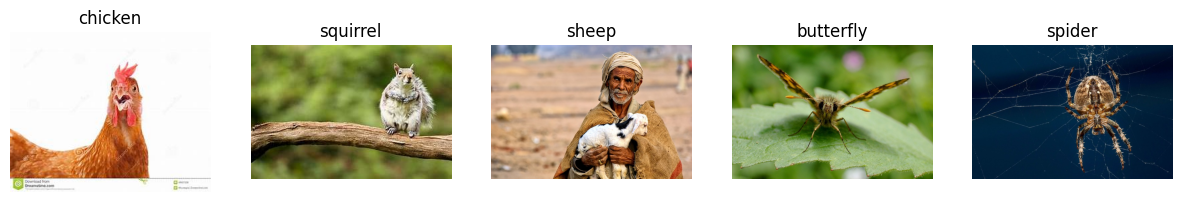

In [53]:
show_original_images("split_data/train", num_images=5)

*Shows images after augmentation & normalization.*

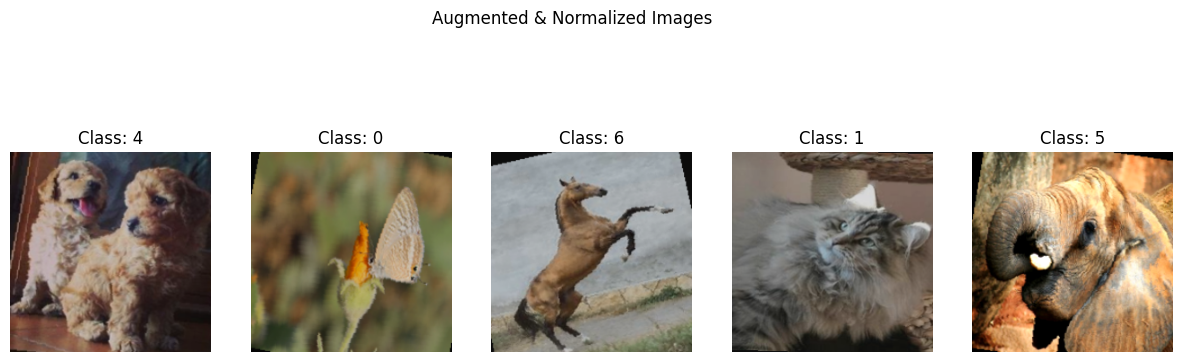

In [54]:
show_augmented_images(standardized_train_loader, "Augmented & Normalized Images")

**Next Step: Model Building!**

Now, I can start training models:

1. Random Forest, XGBoost, FNN
2. Simple CNN Model
3. Deeper CNN Model
4. Transfer Learning (ResNet, VGG, EfficientNet, etc.)